In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# Load the data
df = pd.read_csv('combined.csv')

# Strip any whitespace from column names
df.columns = df.columns.str.strip()

# Columns to remove, including IP addresses and ports which might not generalize well
columns_to_drop = ["flow ID", "source IP", "destination IP", "source port", "destination port", "date"]
df = df.drop(columns=columns_to_drop)

# Handle missing values
# For categorical data, replace missing values with a placeholder string
df.fillna({'protocol': 'Missing', 'firstPacketDIR': 'Missing', 'mostCommonREQ_FUNC_CODE': 'Missing', 
           'mostCommonRESP_FUNC_CODE': 'Missing'}, inplace=True)

# For numerical data, replace missing values with the median
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Encoding categorical variables, including the 'Label' column
label_encoders = {}
categorical_columns = ['protocol', 'firstPacketDIR', 'mostCommonREQ_FUNC_CODE', 'mostCommonRESP_FUNC_CODE', 'Label']  # Include 'Label' as categorical
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Store the encoded labels separately and drop from dataframe
y = df['Label']
X = df.drop('Label', axis=1)

# Feature scaling
scaler = StandardScaler()
numerical_columns = X.select_dtypes(include=[np.number]).columns.tolist()  # Only scale numerical columns
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# Handling imbalanced dataset with SMOTE
smote = SMOTE()
X_res, y_res = smote.fit_resample(X, y)


In [2]:

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# CatBoost setup with hyperparameter tuning using RandomizedSearchCV
model_params = {
    "CatBoost Classifier": {
        "model": CatBoostClassifier(verbose=0),  # Suppress output
        "params": {
            "iterations": [100, 200, 500],
            "learning_rate": [0.01, 0.05, 0.1],
            "depth": [4, 6, 8],
            "l2_leaf_reg": [1, 3, 5, 7]
        }
    }
}

In [3]:

# Training and evaluation with RandomizedSearchCV
for model_name, mp in model_params.items():
    clf = RandomizedSearchCV(mp['model'], mp['params'], n_iter=10, cv=5, scoring='accuracy', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"Best parameters for {model_name}: {clf.best_params_}")
    print(f"Classification report for {model_name}:\n{classification_report(y_test, y_pred)}")

Best parameters for CatBoost Classifier: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 500, 'depth': 6}
Classification report for CatBoost Classifier:
              precision    recall  f1-score   support

           0       0.64      0.64      0.64     32590
           1       1.00      1.00      1.00     32681
           2       0.69      0.74      0.71     32310
           3       0.72      0.67      0.70     32706
           4       0.77      0.73      0.75     32617
           5       1.00      0.99      0.99     32661
           6       0.99      1.00      0.99     32516
           7       0.74      0.78      0.76     32701
           8       0.64      0.65      0.64     32514

    accuracy                           0.80    293296
   macro avg       0.80      0.80      0.80    293296
weighted avg       0.80      0.80      0.80    293296



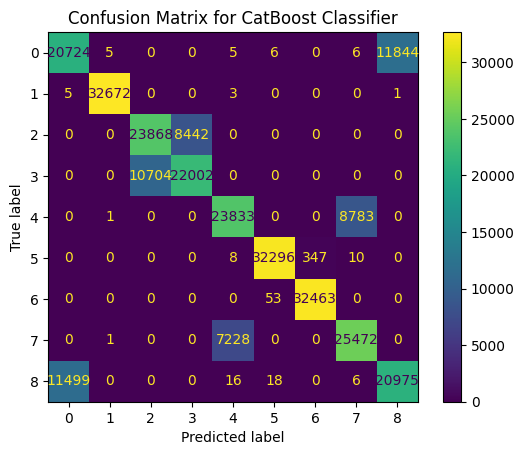

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_conf_matrix(model, X_test, y_test, model_name):
    cm = confusion_matrix(y_test, model.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Example usage:
plot_conf_matrix(clf.best_estimator_, X_test, y_test, model_name)


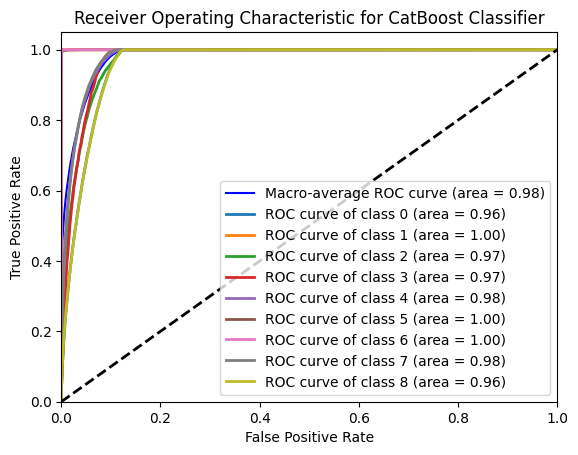

In [5]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

def plot_multiclass_roc_curve(model, X_test, y_test, n_classes, model_name):
    # Binarize the labels for multiclass plotting
    y_test_bin = label_binarize(y_test, classes=[*range(n_classes)])
    y_score = model.predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Average it and compute AUC
    mean_tpr /= n_classes

    plt.figure()
    plt.plot(all_fpr, mean_tpr, color='blue', label=f'Macro-average ROC curve (area = {auc(all_fpr, mean_tpr):.2f})')

    # Plot ROC curve for each class
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Determine the number of classes in your target labels for correct binarization
num_classes = len(np.unique(y_test))  # Adjust according to how y_test is structured
# Example usage:
plot_multiclass_roc_curve(clf.best_estimator_, X_test, y_test, num_classes, model_name)